In [1]:
# set working dir
import os
os.chdir("../")

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc

from run import utils

Auto-Sklearn cannot be imported.


In [3]:
# init config
config = SimpleNamespace()
config.prob = "sp"
config.grid = (5, 5)
config.feat = 5
config.net = []
config.optm = "adam"
config.l1 = 0.0
config.l2 = 0.0
config.batch = 32
config.rel = False
config.lan = "gurobi"
config.proc = 8
config.path = "./res"

In [4]:
# polynomial degree
degs = [1, 2, 4, 6]

In [5]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "spo":
        config.mthd = "spo"
        config.lr = 1e-2
        config.sftp = False
    if mthd == "spo sp":
        config.mthd = "spo"
        config.lr = 1e-2
        config.sftp = True
    if mthd == "dbb":
        config.mthd = "dbb"
        config.loss = "r"
        config.lr = 1e-1
        config.smth = 20
        config.sftp = False
    if mthd == "dbb sp":
        config.mthd = "dbb"
        config.loss = "r"
        config.lr = 1e-1
        config.smth = 20
        config.sftp = True
    path = utils.getSavePath(config)
    return path

In [6]:
def getDf(config, degs, mthd):
    dfs = pd.DataFrame()
    for deg in degs:
        config.deg = deg
        df = pd.read_csv(getPath(config, mthd))
        dfs[deg] = df["Unamb SPO"]
    return dfs

In [7]:
def lighten(color, amount=0.9):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def drawPlot(config, data, noise):
    # set config
    config = deepcopy(config)
    config.data = data
    config.noise = noise
    # color map
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = [cmap[16], cmap[8]]
    for i in range(len(colors)):
        colors[i] = lighten(colors[i])
    # get df
    df_spo   = getDf(config, degs, "spo")
    df_spo_sp = getDf(config, degs, "spo sp")
    df_dbb   = getDf(config, degs, "dbb")
    df_dbb_sp = getDf(config, degs, "dbb sp")
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    c = colors[0]
    bp1 = plt.boxplot(df_spo, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])-0.36, widths=0.18)
    c = colors[0]
    bp2 = plt.boxplot(df_spo_sp, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])-0.12, widths=0.18)
    for box in bp2['boxes']:
        box.set(hatch="....", fill=False)
    c = colors[1]
    bp3 = plt.boxplot(df_dbb, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb.shape[1])+0.12, widths=0.18)
    c = colors[1]
    bp4 = plt.boxplot(df_dbb_sp, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb.shape[1])+0.36, widths=0.18) 
    for box in bp4["boxes"]:
        box.set(hatch="....", fill=False)
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1.5)
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlabel("Polynomial Degree", fontsize=36)
    plt.xticks(ticks=[0,1,2,3], labels=[1,2,4,6], fontsize=28)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.02, 0.33)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.title("Shortest Path\nTraining Set Size = {}, Noise Half−width = {}".format(config.data, config.noise), fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]],
               ["SPO+","SPO+ SoftPlus","DBB","DBB SoftPlus"], fontsize=22, loc=2, labelspacing=0.2,
               handlelength=1, ncol=2)
    # save
    plt.show()
    fig.savefig("./images/reg-sp-n{}e{}.pdf".format(data,int(10*noise)), dpi=300)

## n = 100, e = 0

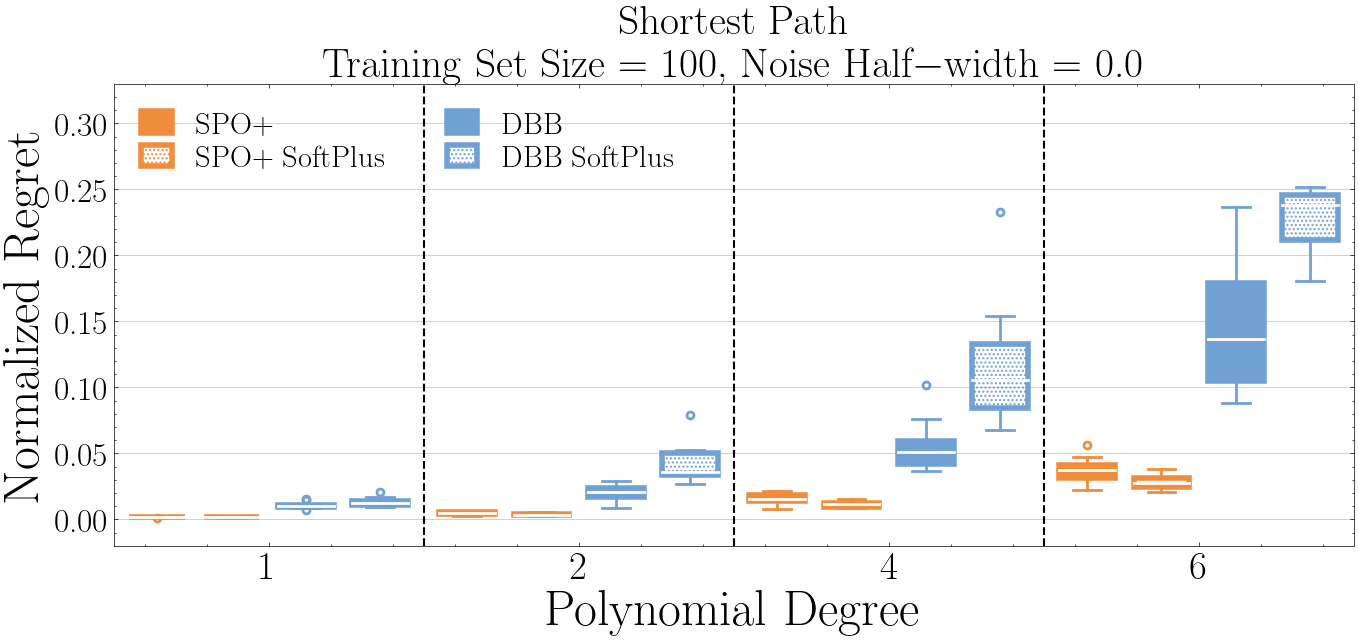

In [9]:
drawPlot(config, data=100, noise=0.0)

## n = 100, e = 0.5 

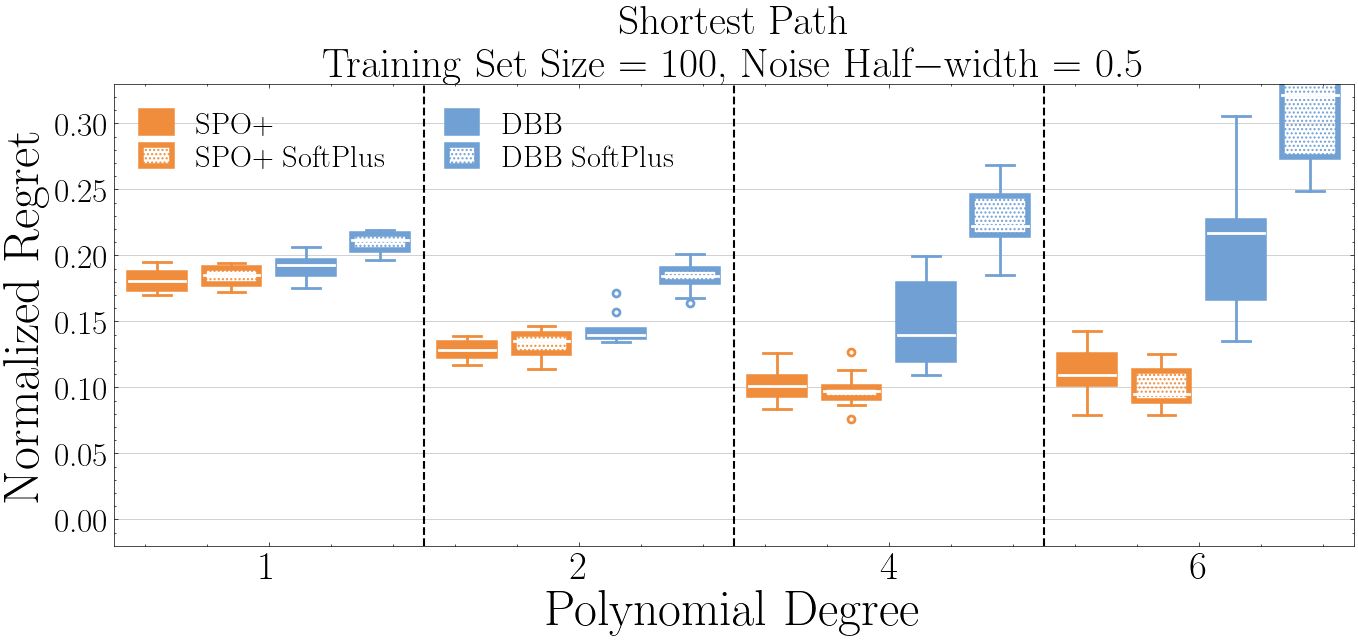

In [10]:
drawPlot(config, data=100, noise=0.5)

## n = 1000, e = 0

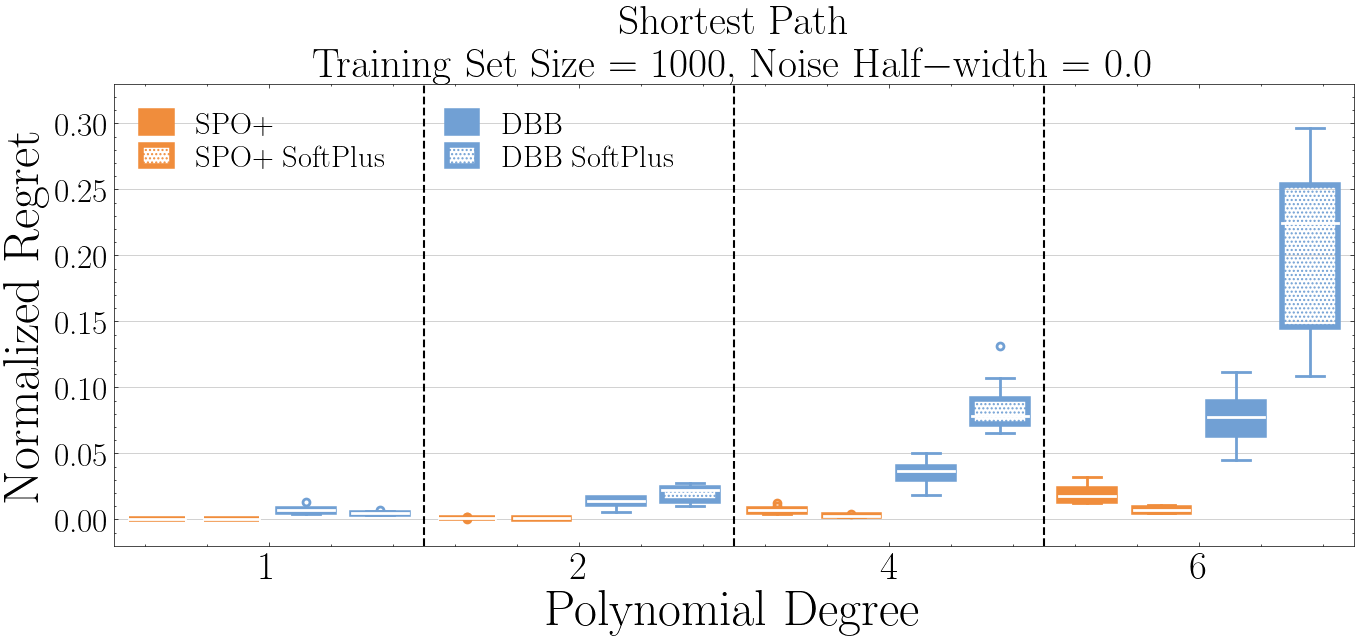

In [11]:
drawPlot(config, data=1000, noise=0.0)

## n = 1000, e = 0.5 

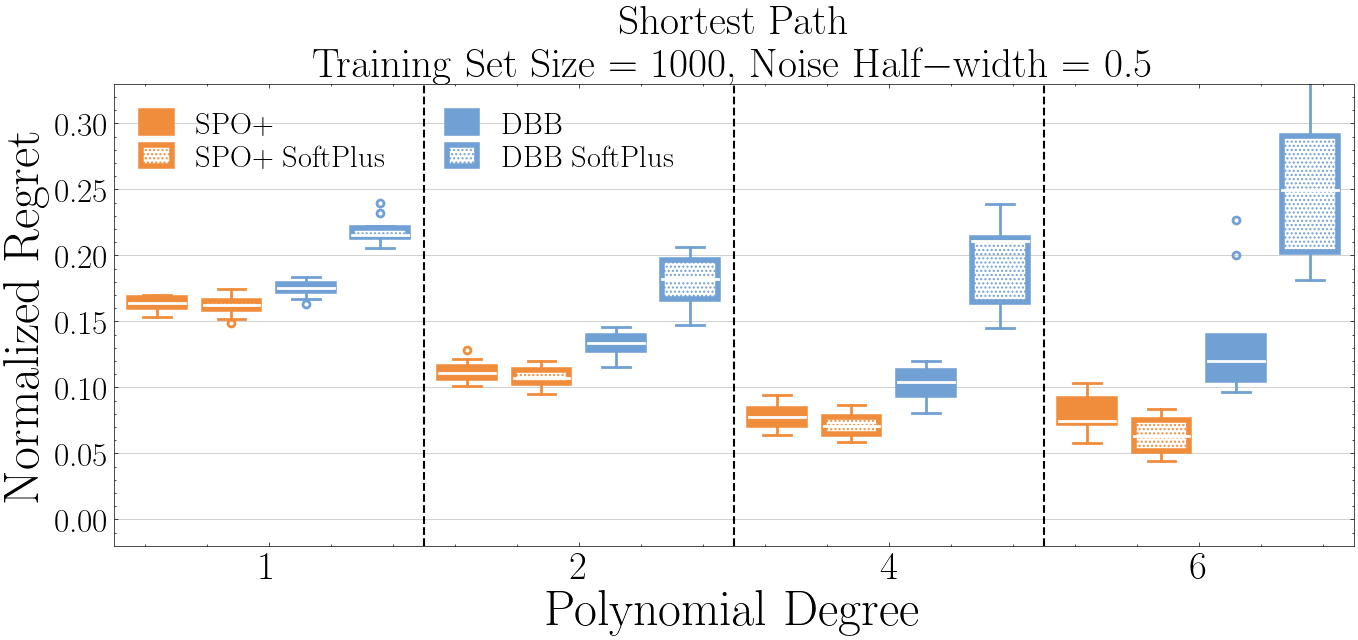

In [12]:
drawPlot(config, data=1000, noise=0.5)

## n = 5000, e = 0.0

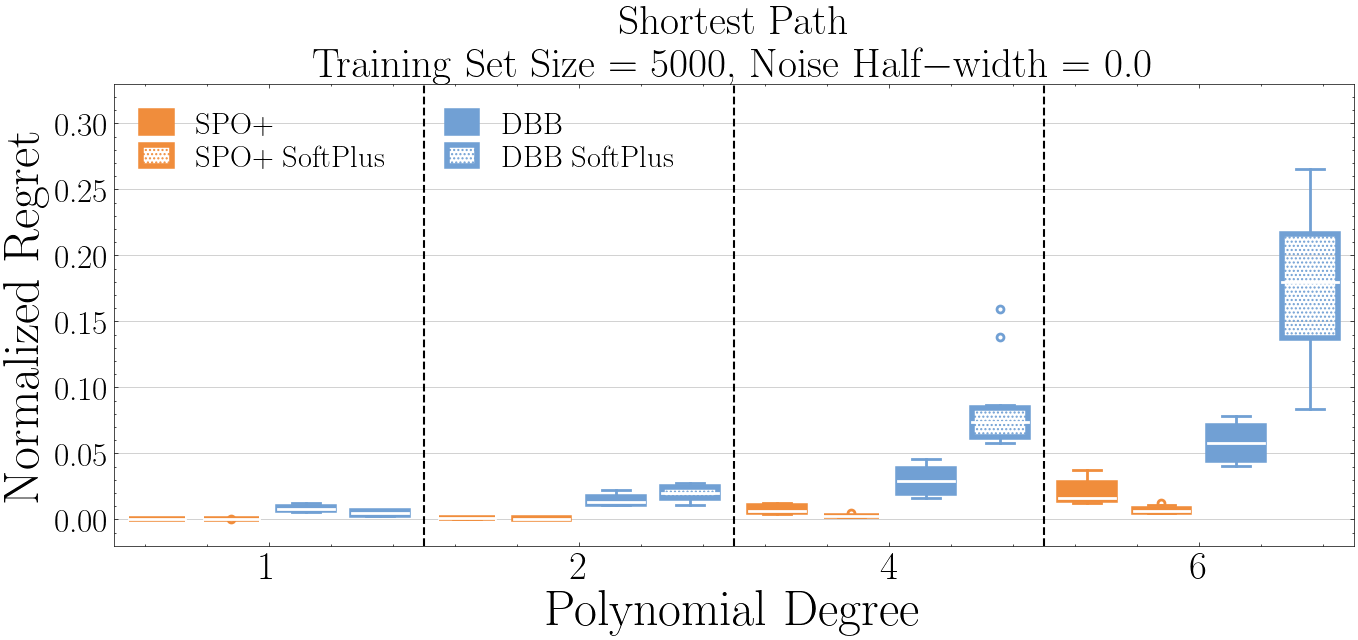

In [13]:
drawPlot(config, data=5000, noise=0.0)

## n = 5000, e = 0.5 

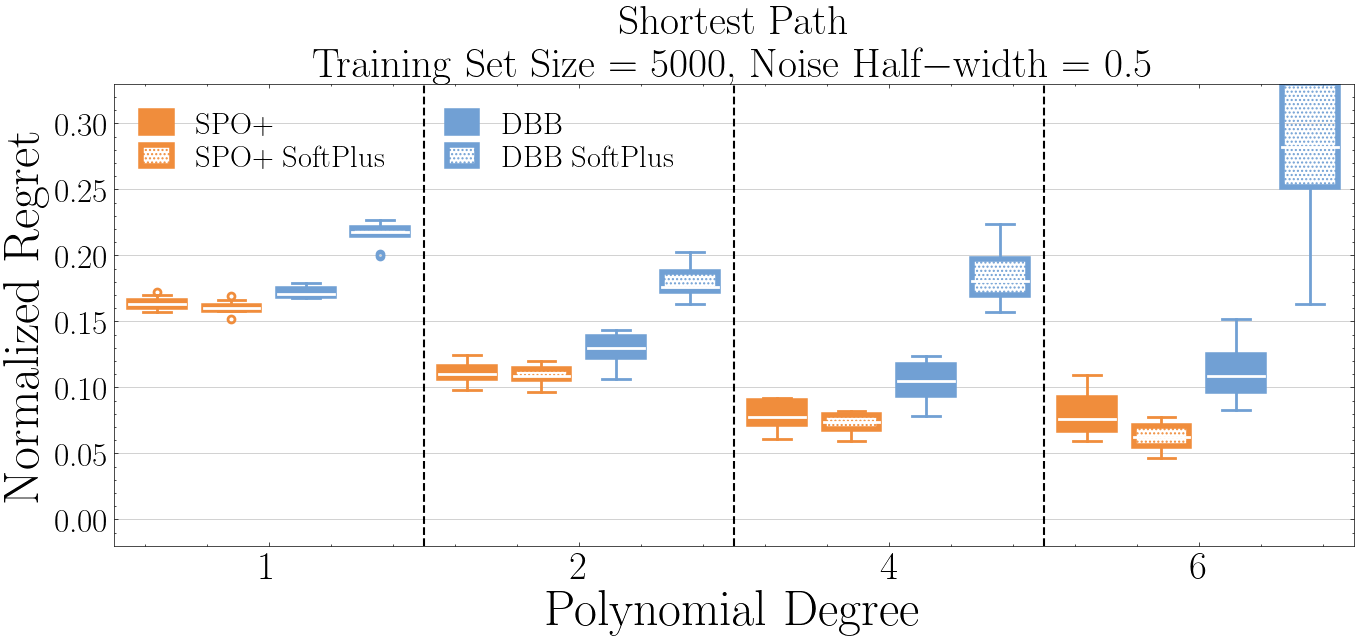

In [14]:
drawPlot(config, data=5000, noise=0.5)